In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
import cvxpy as cp

11368
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

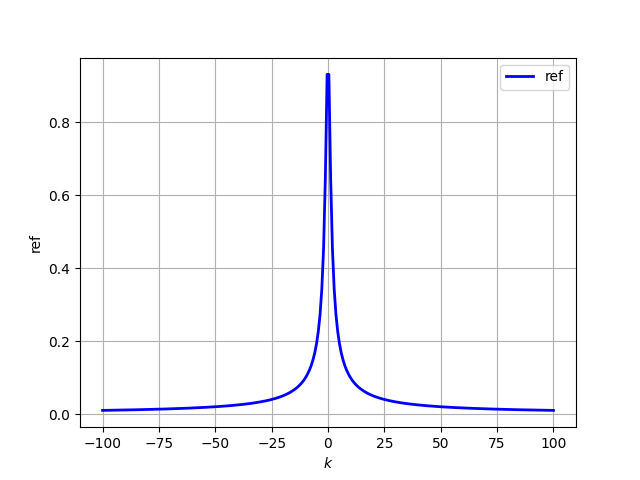

In [28]:
# --------------------------
# --- Reference signal ---
# --------------------------
# nk, kmax = 5, 10
nk, kmax = 8, 100

Nk = 1 << nk
k = np.linspace(-kmax, kmax, Nk)
dk = np.diff(k)[0]

y_ref = np.sqrt(1./(1 + k**2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, y_ref, '-b', linewidth = 2, label = "ref")
plt.xlabel('$k$')
plt.ylabel("ref")
ax.legend()
plt.grid(True)
plt.show()

Reading the file ../QuCF/tests/LCHS-AA//LCHS_AA_OUTPUT.hdf5...
Name of the simulation is LCHS_AA
Simulation has been performed  04-17-2024 17:22:07
succ. prob.: 1.523e-02


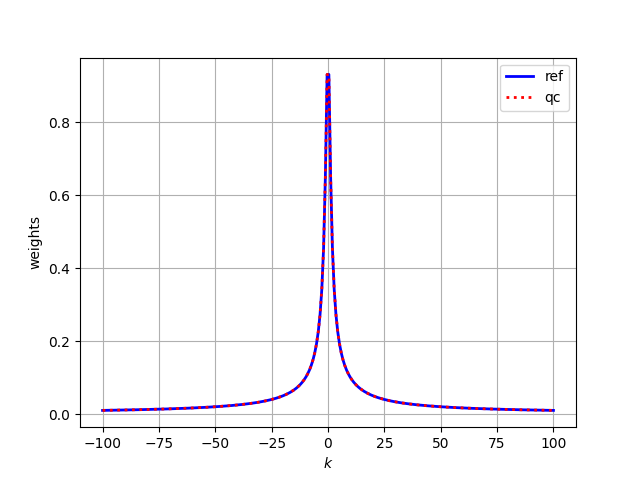

rr = 5.760944577155e-02


In [37]:
# ---------------------------------------------
# --- QuCF simulations ---
# --------------------------------------------- 
mix.reload_module(mix)
mix.reload_module(mse)

# --- Reading qucf data ---
om = mse.MeasOracle__(True)
# om.path_ = "../QuCF/tests/LCHS-USVA-AA/"
# om.pname_ = "LCHS_USVA_AA"
om.path_ = "../QuCF/tests/LCHS-AA/"
om.pname_ = "LCHS_AA"
om.open()
om.set_zero_ancillae_work_states(0)
om.read_qsvt()

# --- qucf signal ---
coef_norm = 2**(nk/2.) * 1./om.dd_["weights"]["rescaling_factor"]
y_qc = om.get_var_x({}, "rk") 
succ_prob = np.sum(np.abs(y_qc)**2)
print("succ. prob.: {:0.3e}".format(succ_prob))

# --- Renormalization of the QC signal ---
y_qc = y_qc.real

# for non-amplified signal:
y_qc *= 1.
y_qc *= coef_norm

# # for amplified signal:
# y_qc *= -1.
# y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)

# --- Plotting results ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, y_ref, '-b', linewidth = 2, label = "ref")
ax.plot(k, y_qc,  ':r', linewidth = 2, label = "qc")
plt.xlabel('$k$')
plt.ylabel("weights")
ax.legend()
plt.grid(True)
plt.show()

y_qc_norm = om.get_var_x({}, "rk")
print("rr = {:0.12e}".format(
    np.max(np.abs(y_qc_norm))
))


# # --- Sin ---
# y_qc = -y_qc.real

# x = np.linspace(-1.0, 1.0, Nk)
# y_ref = np.sin(x)

# y_qc *= 2**(nk/2.) / 1.5

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(x, y_ref, '-b', linewidth = 2, label = "ref")
# ax.plot(x, y_qc,  ':r', linewidth = 2, label = "qc")
# plt.xlabel('$k$')
# plt.ylabel("weibbghts")
# ax.legend()
# plt.grid(True)
# plt.show()

In [38]:
# --- The first number is the amplified rr      ---
# --- The second number is the non-amplified rr ---


print("kmax = 10: aa_ampl/aa_non-ampl = {:0.12e}".format(
    4.156002297806e-01 / 1.682383322842e-01
))

print("kmax = 100: aa_ampl/aa_non-ampl = {:0.12e}".format(
    4.565726282533e-01 / 5.760944577155e-02
))


kmax = 10: aa_ampl/aa_non-ampl = 2.470306404836e+00
kmax = 100: aa_ampl/aa_non-ampl = 7.925308465279e+00


In [30]:
# ------------------------------------------------------------
# --- Compute the number of repetitions of the AA operator ---
# ------------------------------------------------------------

# --0 here, one needs a non-amplified success probability ---
# succ_prob = 1.428e-01  # kmax = 10
succ_prob = 1.523e-02 # kmax = 100

theta_AA_ = np.arcsin(np.sqrt(succ_prob))
N_AA_ = int(0.5 * (np.pi/(2.*theta_AA_) - 1.))  # +/- 1?

print("N_AA {:d}".format(N_AA_))

N_AA 5


Chosen profile: USVA
Chosen parity: 1

Minimization method is used.
Computation status:  0.47481872324605023

Chosen polynomial's degree:	 100
Number of coefficients:		 50
max. abs. error: 3.079e-01


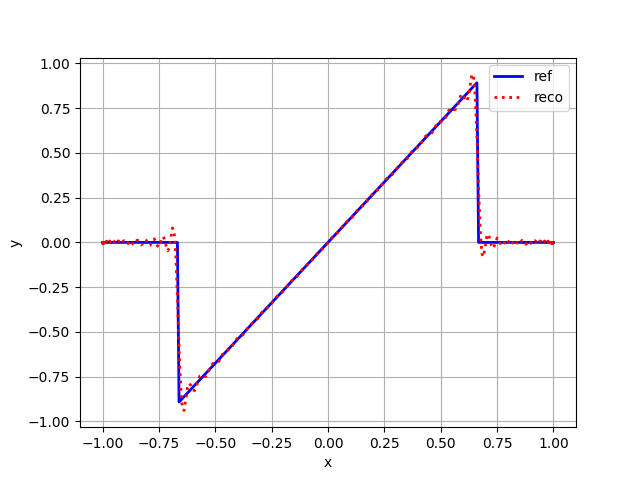

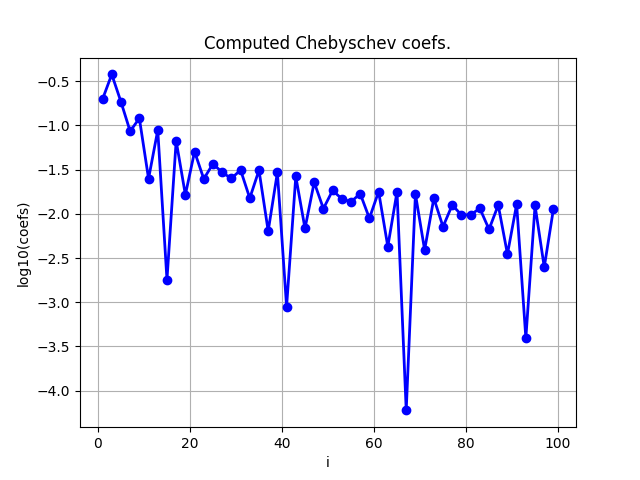

write coefficients to:
 ./tools/QSVT-angles/USVA/coefs//USVA_1_eps0.hdf5


In [110]:
# ----------------------------------------------------------------------------------
# --- Compute parameters for the uniform singular value amplification (standard) ---
# ----------------------------------------------------------------------------------
mix.reload_module(ch)

def compute_USVA_parameters_standard():

    coef_ampl = 1.5      # gamma
    Nd       = 100
    eta_norm = 0.90
    inv_ampl = 1./coef_ampl

    # --- Standard USVA profile ---
    Nx = np.max((10*Nk, Nd))
    # x = np.linspace(-1.0, 1.0, Nx)
    x = ch.get_Cheb_roots(Nx)
    SQ = np.zeros(Nx)
    for ix in range(Nx):
        x1 = x[ix]
        if x1 < -inv_ampl or x1 > inv_ampl:
            SQ[ix] = 0.
        else:
            SQ[ix] = eta_norm
    pol = coef_ampl * x * SQ

    # --- Intermediate step ---
    oo_ch_ = ch.Ch_()
    oo_ch_.choose_method(0)
    oo_ch_.choose_func(
        id_func = -1, 
        par_in = coef_ampl,
        profile_in = pol,
        name_prof = "USVA",
        parity_in = 1,
        path_root_in = "./tools/QSVT-angles/USVA/coefs/",
        x_grid = x
    )
    oo_ch_.compute_Ch(Nd)
    oo_ch_.plot_reconstructed_function()
    oo_ch_.plot_coefficients()
    oo_ch_.save_coefficients()
    return
# --------------------------------------------------------------
compute_USVA_parameters_standard()

max. abs. error: 6.571e-03


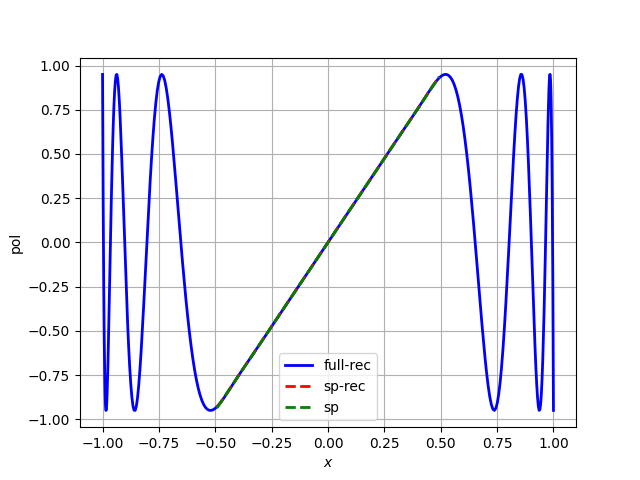

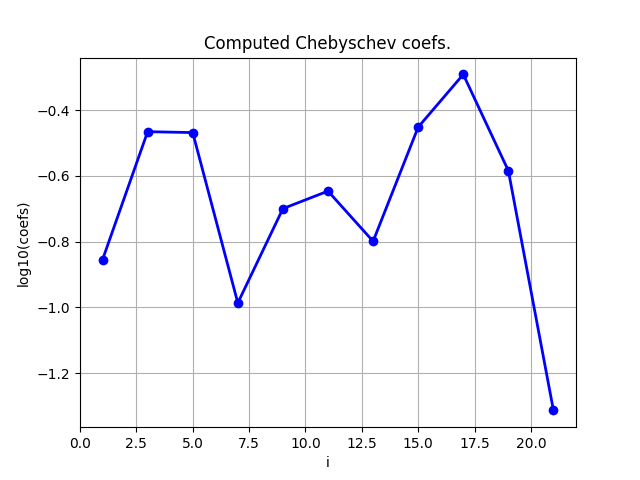

write coefficients to:
 ./tools/QSVT-angles/USVA/coefs//USVA_2_eps2.hdf5


In [57]:
# ---------------------------------------------------------------------------------------
# --- Copmute parameters for the uniform singular value amplification (Fang's method) ---
# ---------------------------------------------------------------------------------------
mix.reload_module(ch)

def compute_USVA_parameters():
    def test_odd_Ch(x, coefs):
        res_pol = 0.
        for ii in range(Nc):
            res_pol += coefs[ii] * np.cos((2*ii+1) * np.arccos(x))
        return res_pol

    def reproduce_odd(x, coefs):
        Nx = len(x)
        res_pol = np.zeros(Nx)
        for ix in range(Nx):
            res_pol[ix] = 0.
            for ii in range(Nc):
                res_pol[ix] += coefs[ii] * np.cos((2*ii+1) * np.arccos(x[ix]))
        return res_pol
    # ------------------------------------------------------------------
    # --- Choose the polynomial degree ---
    coef_ampl = 2      # gamma
    Nd = 22
    eta_norm = 0.95

    Nx = np.max((10*Nk, Nd))
    inv_ampl = 1./coef_ampl

    # --- Fang's profile ---
    x = ch.get_Cheb_roots(Nx)
    x_sp = []
    for x1 in x:
        if x1 >= -inv_ampl and x1 <= inv_ampl:
            x_sp.append(x1)
    x_sp = np.array(x_sp)

    # x = np.linspace(-1.0, 1.0, Nx)
    # x_sp = np.linspace(-inv_ampl, inv_ampl, Nx)
    pol = eta_norm * coef_ampl * x_sp

    # --- Intermediate step ---
    Nc = Nd//2
    coefs = cp.Variable(Nc)
    objective = cp.Minimize(cp.sum_squares(
        test_odd_Ch(x_sp, coefs) - pol
    ))
    cp.Problem(objective, [test_odd_Ch(x, coefs) <= eta_norm]).solve(
        # solver=cp.OSQP
        solver=cp.ECOS
    )

    # --- reproduce the signal ---
    pol_rec_sp   = reproduce_odd(x_sp, coefs.value)
    pol_rec_full = reproduce_odd(x,    coefs.value)
    max_abs_err = np.max(np.abs(pol_rec_sp - pol))
    print("max. abs. error: {:0.3e}".format(max_abs_err))

    # --- Plotting the reconstructed signal ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x,    pol_rec_full,  '-b', linewidth = 2, label = "full-rec")
    ax.plot(x_sp, pol_rec_sp,   '--r', linewidth = 2, label = "sp-rec")
    ax.plot(x_sp, pol,          '--g', linewidth = 2, label = "sp")
    plt.xlabel('$x$')
    plt.ylabel("pol")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Save the coefs ---
    oo_ch_ = ch.Ch_()
    oo_ch_.set_data(
        name = "USVA",
        path_root = "./tools/QSVT-angles/USVA/coefs/",
        coefs = coefs.value,
        parity = 1,
        param = coef_ampl,
        max_abs_err = max_abs_err,
        coef_norm = eta_norm,
        Nd = Nd
    )
    oo_ch_.plot_coefficients()
    oo_ch_.save_coefficients()
    return
# ----------------------------------------------------------------
compute_USVA_parameters()